# 地震目录分析示例

In [27]:
import pathlib
import numpy as np
from geoist.cattools import Catalogue as Cat
from geoist.cattools import Exploration as Exp
from geoist.cattools import MapTools as Map
from geoist.cattools import Selection as Sel
from geoist.cattools import Seismicity as Sem
from geoist.cattools import Declusterer as Declus
from geoist.cattools import Smoothing as Sm
from geoist.cattools import CatUtils as Ct

In [28]:
datapath = pathlib.Path(Ct.__file__).parent.parent
pathname = pathlib.Path(datapath,"dataset","isc-gem-v3.csv")
print(pathname)

C:\Users\chens\Anaconda3\lib\site-packages\geoist\dataset\isc-gem-v3.csv


In [29]:
H = ['Id','','Year','Month','Day','Hour','Minute','Second',
     'Longitude','Latitude','','','','Depth','DepError',
     'MagSize','MagError','','','','','','','','','']
Db = Cat.Database('ISC-GEM')
Db.Import('./isc-gem-v3.csv',Header=H, SkipLine=1, Delimiter=',')

In [30]:
Db.SetField('LocCode','ISC-GEM')
Db.SetField('MagCode','ISC-GEM')
Db.SetField('MagType','MW')

## 地震目录摘要

In [31]:
Db.Info()

Number of Events: 24375
Year Rage: (1900,2012)
Magnitude Rage: (4.98,9.6)
Latitude Rage: (-77.079,86.681)
Longitude Rage: (-179.993,179.999)
Depth Rage: (0.0,693.1)


In [32]:
lon = [70, 135]
lat = [15, 55]
#地震筛选
Db.Filter('Latitude',lat[0],Opr='>=')
Db.Filter('Latitude',lat[1],Opr='<=')
Db.Filter('Longitude',lon[0],Opr='>=')
Db.Filter('Longitude',lon[1],Opr='<=')
Exp.AgencyReport(Db, 'L')

Agency: ISC-GEM | Occurrence: 2223



### 二维时间序列图

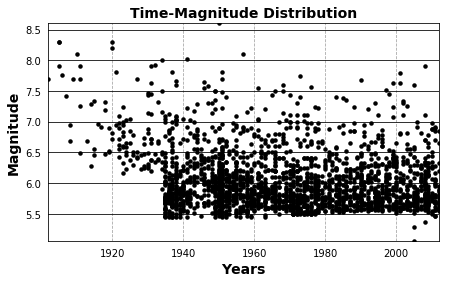

In [33]:
Exp.MagTimePlot(Db)

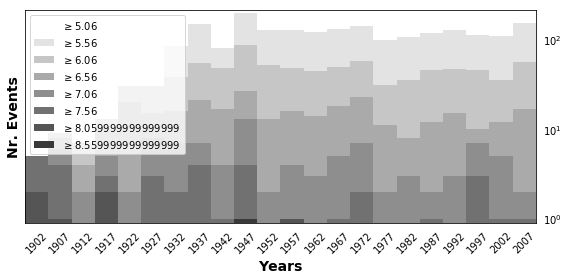

In [34]:
Exp.MagTimeBars(Db)

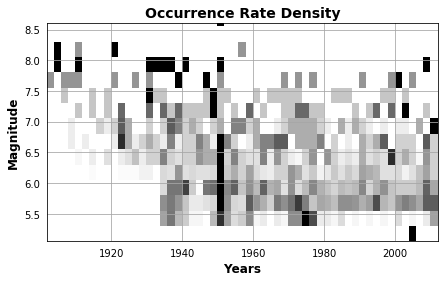

In [35]:
Exp.RateDensityPlot(Db)

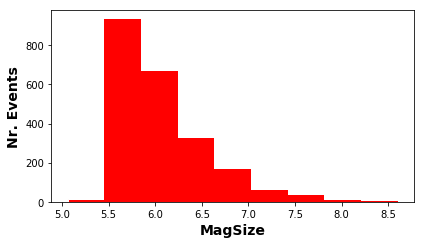

In [36]:
# G-R关系
Enum, Mbin =Exp.GetKeyHisto(Db,'MagSize',Bnum=10, Norm=False) 
Minc= (max(Mbin)-min(Mbin))/10.

In [37]:
#拟合b值
a,b = Sem.MfdOptimize(Enum, Mbin, Minc, max(Mbin))  
print('b-value=',b) 

b-value= 0.35926098163168013


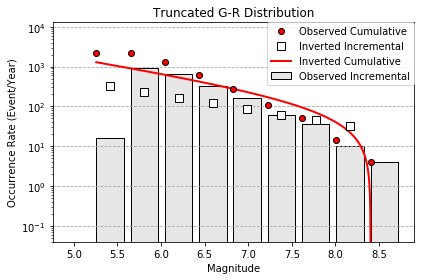

In [38]:
#复发概率
Sem.MfdPlot(a,b, max(Mbin),Enum=Enum, Ecum=np.cumsum(Enum[::-1])[::-1], Mbin=Mbin, Minc=[Minc])

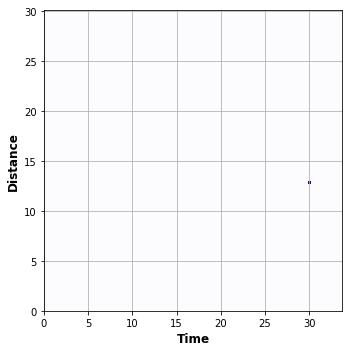

In [39]:
#重复事件监测
Log = Sel.MergeDuplicate(Db,Twin=60.,Swin=50.,Log=1)
Exp.DuplicateCheck(Log)

In [40]:
#去余震
Dbm, Log1 = Declus.WindowSearch(Db)

In [41]:
#目录摘要
Dbm.Info()

Number of Events: 1397
Year Rage: (1902,2012)
Magnitude Rage: (5.44,8.6)
Latitude Rage: (15.033,54.059)
Longitude Rage: (70.033,134.954)
Depth Rage: (0.0,610.0)


90.5 20.5 2282049.561262108 643157.673011438


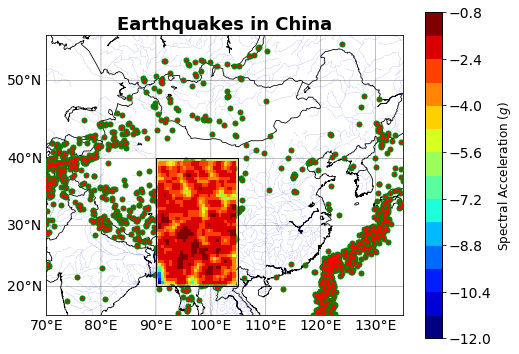

In [44]:
#震中提取
x1,y1,z1 = Exp.GetHypocenter(Db)
x2,y2,z2 = Exp.GetHypocenter(Dbm)

p = [(90.,20.),(90.,40.),(105.,40.),(105.,20.),(90.,20.)]
P = Ct.Polygon()
P.Load(p)
  
cfg = {'Bounds': [70., 15., 135., 55.],
       'FigSize': [8., 6.],
       'Background': ['none',[0.9,0.8,0.6],[0.5,0.8,1.]],
       'Grid': [10., 10.]}

M = Map.GeoMap(cfg)
M.BasePlot()
M.DrawBounds()
M.DrawGrid()
#震中分布图
M.PointPlot(x1, y1, Set=['o','g',5,1], Label='All')
M.PointPlot(x2, y2, Set=['*','r',2,1], Label='Main')
M.AreaPlot(P.x, P.y, Set=['y',0.5,'k',1])
#平滑地震目录
wkt = Ct.XYToWkt(P.x, P.y)
xsm, ysm, asm = Sm.SmoothMFD(Db, 1., wkt, Delta=0.5)
M.MeshPlot(xsm, ysm, asm)
M.Title('Earthquakes in China')
M.Show()